# Sentiment Analysis Exercise  
The goal of the Sentiment Analysis (SA) task is to classify the sentiment within a piece of text. This sentiment can be either binary (positive-negative) or multi-class (a rating scale from 1 to 5).

Data: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz

**Steps to Solve This Exercise:**

1. Load data into a pandas DataFrame
2. Preprocessing & Vectorizing
3. Building Model
4. Evaluation

# Step 1: Load data into a pandas DataFrame

In [15]:
import pandas as pd
import gzip

# URL
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"

# Read file JSON compression
df = pd.read_json(url, compression="gzip", lines=True)

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008"


# Preprocessing & Vectorizing

**Preprocessing**

In [16]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
def preprocess_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    text = re.sub(r"\d+", "", text)  # Xóa số
    text = text.translate(str.maketrans("", "", string.punctuation))  # Xóa dấu câu
    tokens = word_tokenize(text)  # Tách từ
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Bỏ stopwords và lemmatize
    return " ".join(tokens)

In [18]:
df["cleaned_review"] = df["reviewText"].apply(preprocess_text)

In [20]:
df["cleaned_review"].head()

,cleaned_review
0,hard believe memory tree came year agoit held ...
1,clasicallystyled introverted album memory tree...
2,never thought enya would reach sublime height ...
3,third review irish album write today others cr...
4,enya despite successful recording artist doesn...


**Vectorizing and TF-IDF**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_review"])

# Building Model

**First we split the data into train and test set**

In [25]:
from sklearn.model_selection import train_test_split
X_data = X_tfidf; y_data = df["overall"].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=0)

**Using the LosisticRegression model**

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Evaluation

**F1-score and accuracy for each class**

In [32]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
f1_score(y_test, y_pred, average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.38      0.50       273
           2       0.48      0.07      0.12       290
           3       0.48      0.21      0.29       699
           4       0.50      0.36      0.42      1722
           5       0.68      0.93      0.79      3487

    accuracy                           0.64      6471
   macro avg       0.57      0.39      0.42      6471
weighted avg       0.60      0.64      0.59      6471



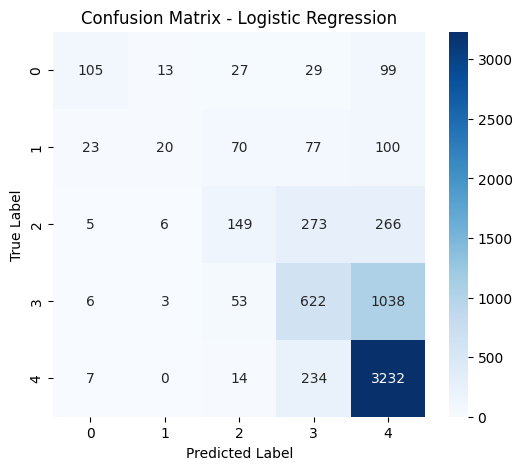

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**The model likely suffers from class imbalance and limited discrimination between similar classes, requiring techniques like resampling, feature engineering, or a more robust classifier to improve accuracy.**

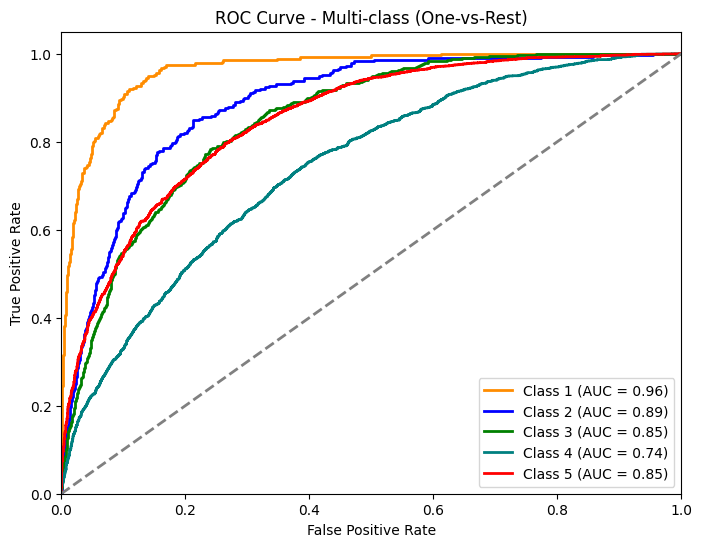

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Lấy số lượng class từ model
n_classes = len(model.classes_)

# Dự đoán xác suất cho từng class
y_score = model.predict_proba(X_test)

# Khởi tạo dictionary chứa FPR, TPR và AUC
fpr, tpr, roc_auc = {}, {}, {}

# Tính FPR, TPR, và AUC cho từng class
for i, class_idx in enumerate(model.classes_):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test == class_idx, y_score[:, i])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Danh sách màu cho từng class
colors = ["darkorange", "blue", "green", "teal", "red", "yellow"]

# Vẽ đồ thị ROC
plt.figure(figsize=(8, 6))
lw = 2
for i, class_idx in enumerate(model.classes_):
    plt.plot(fpr[class_idx], tpr[class_idx], color=colors[i % len(colors)], lw=lw,
             label=f"Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})")

# Vẽ đường baseline
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=lw)

# Thiết lập đồ thị
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class (One-vs-Rest)")
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()
